In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import copy
from datetime import datetime
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import zipfile
import shutil
from PIL import Image
import glob
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 경로 설정
base_dir = "/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data"
zip_path = os.path.join(base_dir, "archive.zip")
extract_path = os.path.join(base_dir, "archive")

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("압축 해제 완료:", extract_path)
else:
    print("폴더 존재:", extract_path)

압축 해제 완료: /content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/archive


In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(os.path.join(root_dir, "*"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# 데이터 경로
data_path = "/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/archive/Images"

dataset = CustomImageDataset(root_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

print("이미지 :", len(dataset))

이미지 : 5734


In [ ]:
# 하이퍼파라미터
nz = 100   # latent vector 크기
ngf = 64   # Generator filter
ndf = 64   # Discriminator filter
nc = 3     # RGB
batch_size = 128
beta1 = 0.5
epochs = 50  # 이번 학습에서 돌릴 epoch 수
checkpoint_dir = "/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/"

os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),          # 64 -> 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),     # 32 -> 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # 16 -> 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # 8 -> 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def weights_init(m):
    cname = m.__class__.__name__
    if cname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif cname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(beta1, 0.999))

In [ ]:
run_best_loss = float("inf")
run_best_epoch = None
run_best = {"netG": None, "netD": None, "optG": None, "optD": None}

# 학습 재개 설정
start_epoch = 0
best_loss = float("inf")

# 재현용 fixed noise (파일 저장 없이 시드로 고정)
NOISE_SEED = 2025
g = torch.Generator(device='cpu').manual_seed(NOISE_SEED)  # CPU에서 생성하면 재현성 좋음
fixed_noise = torch.randn(64, nz, 1, 1, generator=g).to(device)

# 이어서 학습할 체크포인트 지정 (없으면 None)
resume_path = os.path.join(checkpoint_dir, "best_e30.pt")
# 예) resume_path = os.path.join(checkpoint_dir, "best_e80.pt")


if resume_path and os.path.exists(resume_path):
    ckpt = torch.load(resume_path, map_location=device)
    netG.load_state_dict(ckpt["netG"])
    netD.load_state_dict(ckpt["netD"])
    optimizerG.load_state_dict(ckpt["optimizerG"])
    optimizerD.load_state_dict(ckpt["optimizerD"])
    start_epoch = ckpt["epoch"] + 1
    best_loss = ckpt["best_loss"]
    print(f"'{os.path.basename(resume_path)}'에서 이어서: start_epoch={start_epoch}, best_loss={best_loss}")

'best_e30.pt'에서 이어서: start_epoch=30, best_loss=2.1968908200661343


In [ ]:
total_epochs = start_epoch + epochs
for epoch in range(start_epoch, total_epochs):
    netG.train(); netD.train()
    running_lossD, running_lossG, num_batches = 0.0, 0.0, 0

    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # (선택) 초반 10에폭 인스턴스 노이즈 설정
        use_noise = epoch < 10
        if use_noise:
            sigma = 0.1 * (1 - epoch / 10)
            noise_real = sigma * torch.randn_like(real_images)
        else:
            noise_real = None

        b_size = real_images.size(0)

        # 라벨 스무딩
        real_label = torch.empty(b_size, device=device).uniform_(0.85, 0.95)
        fake_label = torch.zeros(b_size, device=device)

        # --- Discriminator ---
        optimizerD.zero_grad(set_to_none=True)

        # D에는 real/fake 모두 노이즈(초반만)
        real_forD = (real_images + noise_real).clamp_(-1, 1) if use_noise else real_images

        out_real = netD(real_forD).view(b_size, -1).squeeze(1)
        lossD_real = criterion(out_real, real_label)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        if use_noise:
            fake_forD = (fake_images.detach() + sigma * torch.randn_like(fake_images)).clamp_(-1, 1)
        else:
            fake_forD = fake_images.detach()

        out_fake = netD(fake_forD).view(b_size, -1).squeeze(1)
        lossD_fake = criterion(out_fake, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # --- Generator ---
        optimizerG.zero_grad(set_to_none=True)

        # G는 '깨끗한' fake로 학습 (노이즈 X)
        out_fake_forG = netD(fake_images).view(b_size, -1).squeeze(1)
        lossG = criterion(out_fake_forG, torch.ones_like(out_fake_forG, device=device))
        lossG.backward()
        optimizerG.step()

        running_lossD += lossD.item()
        running_lossG += lossG.item()
        num_batches += 1

    # 에폭 평균
    avg_lossD = running_lossD / max(1, num_batches)
    avg_lossG = running_lossG / max(1, num_batches)
    avg_loss  = 0.5 * (avg_lossD + avg_lossG)
    print(f"[{epoch+1}/{total_epochs}] Loss_D: {avg_lossD:.4f}  Loss_G: {avg_lossG:.4f}  Avg: {avg_loss:.4f}")

    if avg_loss < run_best_loss:
        run_best_loss = avg_loss
        run_best_epoch = epoch
        run_best["netG"] = copy.deepcopy(netG.state_dict())
        run_best["netD"] = copy.deepcopy(netD.state_dict())
        run_best["optG"] = copy.deepcopy(optimizerG.state_dict())
        run_best["optD"] = copy.deepcopy(optimizerD.state_dict())


[31/80] Loss_D: 0.7301  Loss_G: 4.1035  Avg: 2.4168
[32/80] Loss_D: 0.6989  Loss_G: 3.7443  Avg: 2.2216
[33/80] Loss_D: 0.7121  Loss_G: 3.7532  Avg: 2.2326
[34/80] Loss_D: 0.5891  Loss_G: 3.8894  Avg: 2.2392
[35/80] Loss_D: 0.7552  Loss_G: 3.7407  Avg: 2.2480
[36/80] Loss_D: 0.6962  Loss_G: 4.0066  Avg: 2.3514
[37/80] Loss_D: 0.6084  Loss_G: 3.8613  Avg: 2.2348
[38/80] Loss_D: 0.6440  Loss_G: 4.1769  Avg: 2.4104
[39/80] Loss_D: 0.7394  Loss_G: 4.0721  Avg: 2.4058
[40/80] Loss_D: 0.5454  Loss_G: 4.1609  Avg: 2.3531
[41/80] Loss_D: 0.5827  Loss_G: 4.1014  Avg: 2.3420
[42/80] Loss_D: 0.5561  Loss_G: 4.3264  Avg: 2.4412
[43/80] Loss_D: 0.7306  Loss_G: 4.4778  Avg: 2.6042
[44/80] Loss_D: 0.5264  Loss_G: 4.1022  Avg: 2.3143
[45/80] Loss_D: 0.6660  Loss_G: 4.6451  Avg: 2.6555
[46/80] Loss_D: 0.5130  Loss_G: 3.9690  Avg: 2.2410
[47/80] Loss_D: 0.6116  Loss_G: 4.4347  Avg: 2.5231
[48/80] Loss_D: 0.5492  Loss_G: 4.2145  Avg: 2.3819
[49/80] Loss_D: 0.4698  Loss_G: 4.2542  Avg: 2.3620
[50/80] Loss

In [ ]:
# best.pt 저장
save_name = f"best_e{run_best_epoch+1}.pt"
save_path = os.path.join(checkpoint_dir, save_name)

torch.save({
    "epoch": run_best_epoch,
    "netG": run_best["netG"],
    "netD": run_best["netD"],
    "optimizerG": run_best["optG"],
    "optimizerD": run_best["optD"],
    "best_loss": run_best_loss
}, save_path)
print(f"{save_name} 저장 (loss={run_best_loss:.4f})")

best_e65.pt 저장 (loss=2.0958)


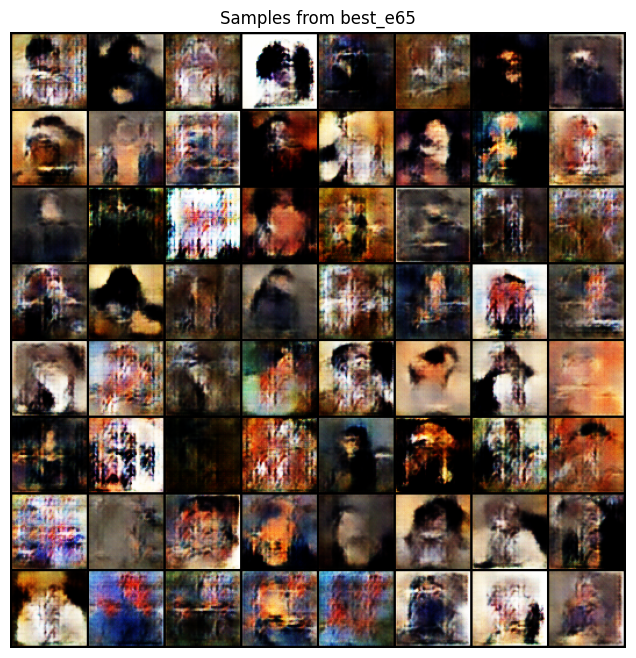

In [ ]:
ckpt_path = save_path  # 방금 저장한 best_e*.pt
ckpt = torch.load(ckpt_path, map_location=device)

# 새 인스턴스에 로드해서 생성(훈련 그래프 간섭 방지)
_G = Generator(nz, ngf, nc).to(device)
_G.load_state_dict(ckpt["netG"])
_G.eval()

# 동일 시드로 fixed_noise 재생성
g = torch.Generator(device='cpu').manual_seed(NOISE_SEED)
fixed_noise = torch.randn(64, nz, 1, 1, generator=g).to(device)

with torch.no_grad():
    fake = _G(fixed_noise).detach().cpu()
    fake = (fake + 1) / 2
    fake.clamp_(0, 1)
    grid = vutils.make_grid(fake, nrow=8, padding=2)

sample_dir = os.path.join(checkpoint_dir, f"samples_from_best_e{ckpt['epoch']+1}")
os.makedirs(sample_dir, exist_ok=True)
vutils.save_image(grid, os.path.join(sample_dir, "sample.png"))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"Samples from best_e{ckpt['epoch']+1}")
plt.imshow(grid.permute(1,2,0).numpy())
plt.show()